this is interesting. try to calculate where the building should have stopped at with building peaks.
figure out where the building should have stopped. look at when the building DID stop as the indicator. 
- there was no more building incentive so people stopped. 
     - why was there no more building incentive? 
- home prices had either stagnated or fallen off. 
    - why did home prices fall off or stagnate?
- could be a lot of reasons(economy, interest rates rise, etc) also could be housing market has been saturated
- this housing line should follow a trend line with the population growth. there should always be about 4% of housing available. 
    - more than 4% available pulls prices down which disincentivizes the builders
    - less that 4% pushes prices up for new housing and incentivizes building
    


# UNDERSTANDING THE AUSTIN HOUSING MARKET BY LOOKING AT NEW HOUSING SUPPLY

There are a nearly infinite variety of factors that influence pricing in any housing market, but to simplify things for easier comprehension, it can be helpful to summarize those factors into the categories of supply and demand. If a giant, foreign investment company collapses and liquidates assets in the region, you can just think of it as a bump in supply. If the region is trending as the "Best Place to Move" by influencers and landed major tech company relocations, these are just examples of increases in demand. The most common way to measure the demand in an area is with changes in home pricing. When demand goes up, buyers compete with higher prices. But these forces dont play out in isolation, and as prices rise the incentive for builders and investors to create new housing rises. So another great metric to look at to understand the demand in a housing market is the amount of new construction happening. 

Austin has a great [data set](https://data.austintexas.gov/Building-and-Development/Issued-Construction-Permits/3syk-w9eu) containing all of the city's building permits since about 1980, and using this data we can create a chart that shows the demand for new construction over time. 

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sodapy import Socrata 

# set chart theme
sns.set_theme(context='notebook', style='darkgrid', 
                  palette='deep', font='sans-serif', font_scale=1.3, color_codes=True, rc=None)

# set pandas display options
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# turning off warnings
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [3]:
def download_data():
    """Downloading selected building permit data from Austin city API.
    
    note: The data selected is intended to be used to calculate the total new housing units permitted and 
    constructed in Austin, so the permit type, work class and permit class have all been limited to query
    only the permits that result in new housing units being added. Also, the selected data set does not account
    for the housing units that get demolished, so will likely be a higher total count than the actual count.
    """
    URL ='data.austintexas.gov'

    client = Socrata(URL,
                     None,
                     timeout=100) #replace None with my token when I get one
# line 36 , "Shell"
    query = """
        select
                permit_number,
                description,
                permittype,
                work_class,
                housing_units,
                completed_date,
                permit_class,
                status_current,
                issue_date,
                original_zip,
                total_job_valuation,
                council_district,
                condominium,
                number_of_floors
        where
                permittype = "BP"
                and work_class in ("New")
                and permit_class in ( 
                                    "C- 101 Single Family Houses", 
                                    "C- 103 Two Family Bldgs",
                                    "C- 104 Three & Four Family Bldgs", 
                                    "C- 105 Five or More Family Bldgs", 
                                    "C- 106 Mixed Use", 
                                    "R- 101 Single Family Houses", 
                                    "R- 102 Secondary Apartment",
                                    "R- 103 Two Family Bldgs", 
                                    "R- 436 Addn to increase housing units"
    )
        limit 
                1000000

    """

    results = client.get("3syk-w9eu", query=query)

    df = pd.DataFrame.from_dict(results)
    # saving the raw data df
    # df.to_csv("forcast_data.csv")
    
    client.close()
    return  df

raw = download_data()
print(raw.shape)
raw.head(1)


(125517, 14)


,permit_number,description,permittype,work_class,housing_units,permit_class,status_current,issue_date,original_zip,total_job_valuation,council_district,condominium,number_of_floors,completed_date
0,2007-139745 BP,New 2story singlefamily residence attached garage covered porch,BP,New,1,R- 101 Single Family Houses,VOID,2007-07-30T00:00:00.000,78735,165000,8,No,2,NaN


In [4]:
# -------- manipulating the data ------

# adding col for building type

def adding_building_type(df):
    """take austin housing data df and classify building 1 fam, 2-4 fam or 5+"""
    
    # dictionary for mapping values
    class_d = {
        "C- 101 Single Family Houses":'single family',
        "R- 101 Single Family Houses":'single family',
        'C- 103 Two Family Bldgs': '2-4 family',
        'C- 104 Three & Four Family Bldgs': '2-4 family',
        'R- 102 Secondary Apartment': 'single family',
        'R- 103 Two Family Bldgs': '2-4 family',
        'R- 436 Addn to increase housing units': '2-4 family',
        'C- 105 Five or More Family Bldgs': '5+ family',
        'C- 106 Mixed Use': '5+ family'}                                   

    df['type'] = df['permit_class'].map(class_d)
    return df

def transform_data(df):
    """Take in selected columns from selected building permits and aggregate to return a dataframe with total
    new housing unit count permitted and finalized new housing unit count for each year.
    """

     # turning housing units value into integer
    df['Housing Units'] = df['housing_units'].astype('float')   

    # filling zero values for single family homes
    mask = (
            (df['type']=='single family') & 
            (df['Housing Units']==0)
    )
    df.loc[mask,'Housing Units'] = 1
    # df['housing_units'].fillna(0, inplace=True) - this is a legacy line, prob for total database
    
    df['issue_date'] = pd.to_datetime(df['issue_date'])
    df['completed_date'] = pd.to_datetime(df['completed_date'])
    
    return df
    
def add_condo_type(df):
    """adding condo type category to type column"""
    mask = df['condominium']=='Yes'
    df.loc[mask, 'type'] = 'condo'
    return df

def adjust_errors(df):
    """adjusting values for one error outlier"""
    error_mask = df['permit_number']=='2003-014585 BP'
    df.loc[error_mask, 'Housing Units'] = 1
    df.loc[error_mask, 'type'] = 'single family'
    return df

df = adding_building_type(raw)
df = add_condo_type(df)
df = transform_data(df)
df = adjust_errors(df)

df.head(1)

,permit_number,description,permittype,work_class,housing_units,permit_class,status_current,issue_date,original_zip,total_job_valuation,council_district,condominium,number_of_floors,completed_date,type,Housing Units
0,2007-139745 BP,New 2story singlefamily residence attached garage covered porch,BP,New,1,R- 101 Single Family Houses,VOID,2007-07-30,78735,165000,8,No,2,NaT,single family,1.0


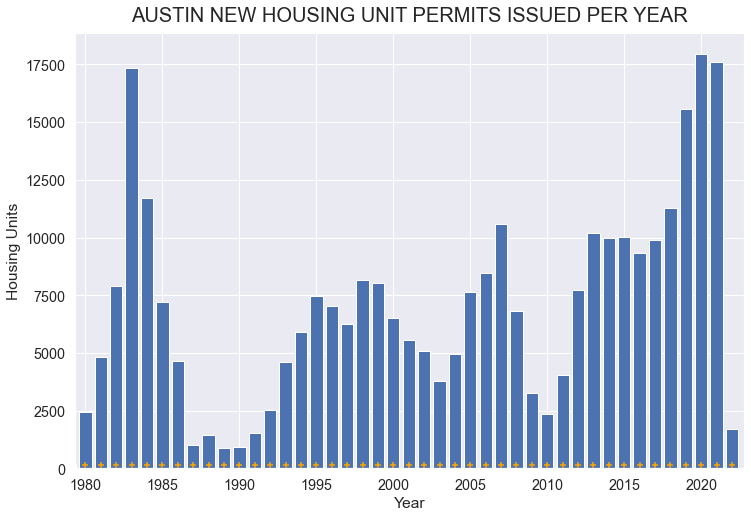

In [88]:
# graphing demand as permits per year

fig, axs = plt.subplots(figsize=(12, 8))
h = df.groupby(df['issue_date'].dt.year, axis=0)['Housing Units'].sum()

axs.bar(h.index, height = h)
axs.scatter(h.index, [150 for x in range(len(h.index))], marker='+', color='orange')
plt.xlabel("Year")
plt.xlim([pd.to_datetime('1979-01-01').year+.3, pd.to_datetime('2023-01-01').year-.2])
plt.ylabel("Housing Units")
plt.title("AUSTIN NEW HOUSING UNIT PERMITS ISSUED PER YEAR", pad=12, fontdict = {'fontsize':20, 'fontweight':'light'})
plt.show()

The above chart is a way of representing the demand for housing in Austin. Now it is easy to see that there was a lot of demand for housing in 1983, and very little demand for housing in 1990. But to have context to understand the relative value of the demand we need to illustrate the supply. Below, I use the same dataset but instead of housing units permitted, I use the number of housing units that are built and arrive to the market for each year. Although these measures seem very similar, they can be quite different because of the time it takes to build housing units to fulfill the demand. These measures would be identical if housing could be built instantly, but some large, multi-unit buildings can take 3+ years to arrive to market and a lot can change in that time. 

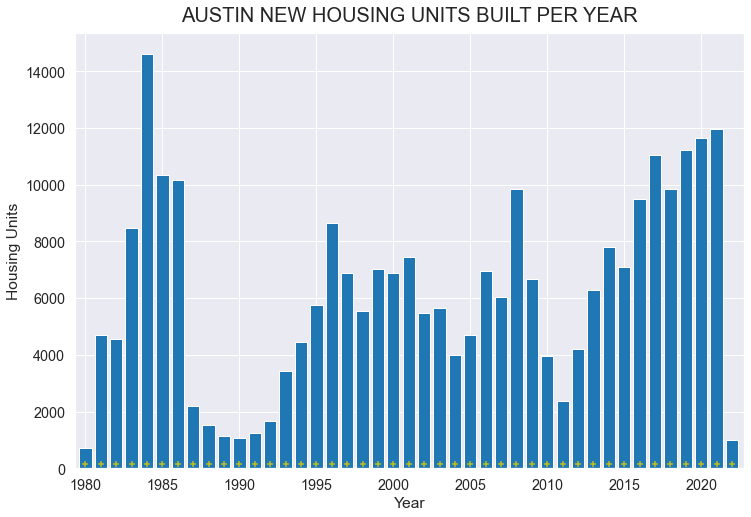

In [155]:
# graphing demand with supply as units built per year
qualitative_colors = sns.color_palette("tab10", 10)

#h = df.groupby(df['issue_date'].dt.year, axis=0)['Housing Units'].sum()
b = df.groupby(df['completed_date'].dt.year, axis=0)['Housing Units'].sum()

fig, axs = plt.subplots(figsize=(12, 8))


axs.bar(b.index, height = b, label='Housing Supply', color = qualitative_colors[0])
axs.scatter(h.index, [150 for x in range(len(h.index))], marker='+', color=qualitative_colors[8]) 
#axs.plot(b.index, b, marker='o', label = 'Housing Supply', color=qualitative_colors[1] )


plt.xlabel("Year")
plt.xlim([pd.to_datetime('1979-01-01').year+.3, pd.to_datetime('2023-01-01').year-.2])
plt.ylabel("Housing Units")
plt.title("AUSTIN NEW HOUSING UNITS BUILT PER YEAR", pad=12, fontdict = {'fontsize':20, 'fontweight':'light'})
#plt.legend()
plt.show()


Although these measures seem very similar, they can be quite different because of the time it takes to build housing units to fulfill the demand. These measures would be identical if housing could be built instantly, but some large, multi-unit buildings can take 3+ years to arrive to market and a lot can change in that time. Below are the supply and demand values plotted as lines. Notice how the peaks and valleys of the supply line are similar to the demand peaks and valleys, but offset by about a year or two. 

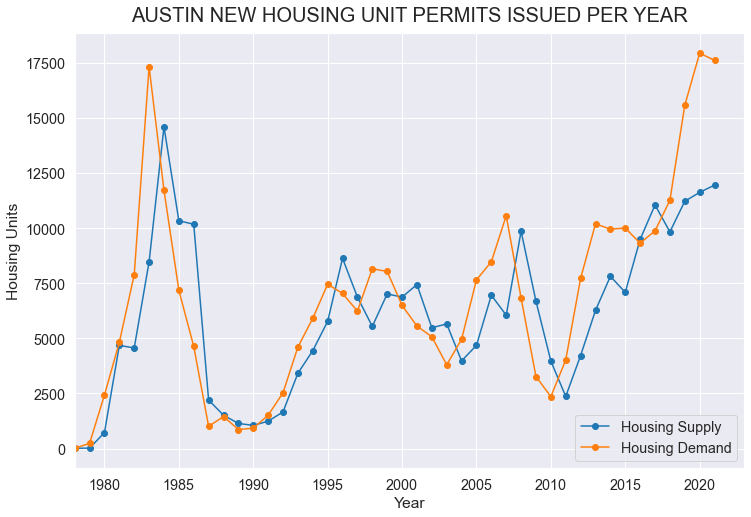

In [161]:
# graphing demand with supply as units built per year
qualitative_colors = sns.color_palette("tab10", 10)

h = df.groupby(df['issue_date'].dt.year, axis=0)['Housing Units'].sum()
b = df.groupby(df['completed_date'].dt.year, axis=0)['Housing Units'].sum()

# limit mask to only show completed data (through 2021, NOT including 2022)
h_limit_mask = h.index < pd.to_datetime('2022-01-01').year
b_limit_mask = b.index < pd.to_datetime('2022-01-01').year

fig, axs = plt.subplots(figsize=(12, 8))

axs.plot(b.index[b_limit_mask], b[b_limit_mask], marker='o', label='Housing Supply', color = qualitative_colors[0])
#axs.scatter(h.index, [150 for x in range(len(h.index))], marker='+', color=qualitative_colors[8], label='Year Marker')
axs.plot(h.index[h_limit_mask], h[h_limit_mask], marker='o', label = 'Housing Demand', color=qualitative_colors[1] )


plt.xlabel("Year")
plt.xlim([pd.to_datetime('1978-01-01').year, pd.to_datetime('2023-01-01').year])
plt.ylabel("Housing Units")
plt.title("AUSTIN NEW HOUSING UNIT PERMITS ISSUED PER YEAR", pad=12, fontdict = {'fontsize':20, 'fontweight':'light'})
plt.legend()
plt.show()

Also notice how the lines cross back and forth, years where the orange line is on top means that more housing units were demanded than were able to be produced, and years when the blue line is on top means that more housing units were built than new units were demanded. In this instance, we know that the demand is causal because a permit getting issued causes a unit to be built, and a unit can NOT be built unless a permit is issued first. If we frame this graph in terms of the difference between demand and supply we can see the number of "unbuilt" houses per year. Think of this yearly "unbuilt" as the annual housing supply "deficit" and this deficit can be positive or negative. In years where the orange line is on top there is a positive housing deficit that adds to the cumulative total of housing units that are permitted but not built, and years where the blue line is on top the deficit is negative and reduces the running total number of unbuilt housing units. While the deficit can be positive or negative on a given year, the running total or housing unit "debt" can only go as low as zero, since a negative number would mean that more housing units have been built than have been permitted overall.  

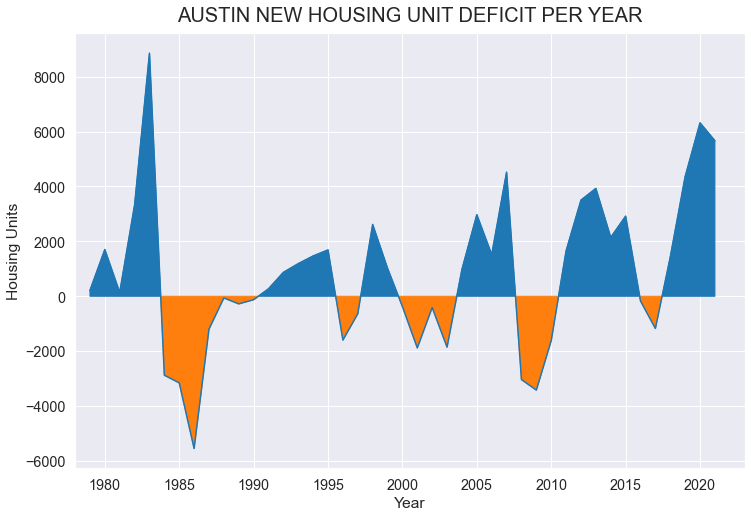

In [191]:
# charting the annual deficit
qualitative_colors = sns.color_palette("tab10", 10)

h = df.groupby(df['issue_date'].dt.year, axis=0)['Housing Units'].sum()
b = df.groupby(df['completed_date'].dt.year, axis=0)['Housing Units'].sum()

# limit mask to only show completed data (through 2021, NOT including 2022)
h_limit_mask = (
                (h.index < pd.to_datetime('2022-01-01').year) &
                (h.index > pd.to_datetime('1978-01-01').year)
)

b_limit_mask = (
                (b.index < pd.to_datetime('2022-01-01').year) &
                (b.index > pd.to_datetime('1978-01-01').year)
)

fig, axs = plt.subplots(figsize=(12, 8))

# calculating the deficit values
deficit = h[h_limit_mask] - b[b_limit_mask]

axs.plot(h.index[h_limit_mask], deficit,  label = 'Housing Demand', color=qualitative_colors[0], animated=True, fillstyle='full' )

plt.fill_between(
    h.index[h_limit_mask],
    y1=deficit,
    y2=0,
    where=deficit > 0,
    interpolate=True,
    color=qualitative_colors[0]
)
plt.fill_between(
    h.index[h_limit_mask],
    y1=deficit,
    y2=0,
    where=deficit < 0,
    interpolate=True,
    color=qualitative_colors[1]
)

plt.xlabel("Year")
plt.xlim([pd.to_datetime('1978-01-01').year, pd.to_datetime('2023-01-01').year])
plt.ylabel("Housing Units")
plt.title("AUSTIN NEW HOUSING UNIT DEFICIT PER YEAR", pad=12, fontdict = {'fontsize':20, 'fontweight':'light'})
#plt.legend()
plt.show()

This graph is pretty hard to make sense of by itself, but what we can see is that what goes up seems to come back down. Why is this? Simply put: overbuilding. There is a positive feedback loop where when supply becomes low, demand will be relatively higher raising prices and incentivizing new construction until the supply becomes high enough to cause prices to drop and building to slow. But because some large buildings can take years to complete, the demand will often be satisfied before the market can send the signal to builders to stop building. The result is overbuilding, there is more housing supply than the market demands. Notice here how the level of building seems to correspond to the level of deficit that follows. 

But the market does not work well if it is too "tight", having a little bit of excess housing in the market allows for new people to enter the market and for people to have options when they decide to move. Below we take a look at the Austin housing market in terms of cumulative deficit, or housing supply "debt" for each year. 

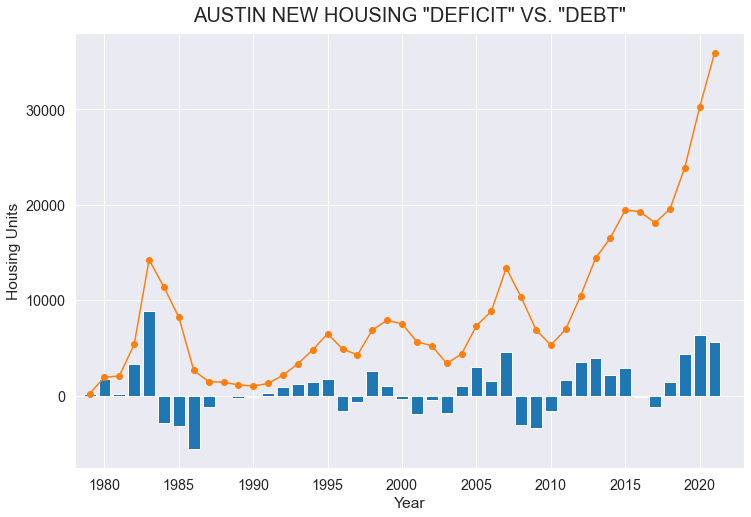

In [207]:
# aggregate housing supply "debt"
qualitative_colors = sns.color_palette("tab10", 10)

h = df.groupby(df['issue_date'].dt.year, axis=0)['Housing Units'].sum()
b = df.groupby(df['completed_date'].dt.year, axis=0)['Housing Units'].sum()

# limit mask to only show completed data (through 2021, NOT including 2022)
h_limit_mask = (
                (h.index < pd.to_datetime('2022-01-01').year) &
                (h.index > pd.to_datetime('1978-01-01').year)
)

b_limit_mask = (
                (b.index < pd.to_datetime('2022-01-01').year) &
                (b.index > pd.to_datetime('1978-01-01').year)
)

fig, axs = plt.subplots(figsize=(12, 8))

# calculating the deficit values
debt = (h[h_limit_mask] - b[b_limit_mask]).cumsum()

axs.plot(h.index[h_limit_mask], debt,  label = 'Housing Demand', color=qualitative_colors[1], marker='o' )
axs.bar(h.index[h_limit_mask], height=deficit, color=qualitative_colors[0])

plt.xlabel("Year")
plt.xlim([pd.to_datetime('1978-01-01').year, pd.to_datetime('2023-01-01').year])
plt.ylabel("Housing Units")
plt.title('AUSTIN NEW HOUSING "DEFICIT" VS. "DEBT"', pad=12, fontdict = {'fontsize':20, 'fontweight':'light'})
#plt.legend()
plt.show()
